# Прогноз продаж игр

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.<br>
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.<br>
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
sns.set(style="whitegrid")

## Шаг 1. Откройте файл с данными и изучите общую информацию

Изучим данные таблицы.

In [2]:
games = pd.read_csv('/datasets//games.csv')

In [3]:
#рассмотрим первые пять строк
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Описание данных<br>
Name — название игры<br>
Platform — платформа<br>
Year_of_Release — год выпуска<br>
Genre — жанр игры<br>
NA_sales — продажи в Северной Америке (миллионы проданных копий)<br>
EU_sales — продажи в Европе (миллионы проданных копий)<br>
JP_sales — продажи в Японии (миллионы проданных копий)<br>
Other_sales — продажи в других странах (миллионы проданных копий)<br>
Critic_Score — оценка критиков (максимум 100)<br>
User_Score — оценка пользователей (максимум 10)<br>
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.<br>
Данные за 2016 год могут быть неполными.<br>

In [4]:
#общая информация о таблице
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
#пустые значения
games.isnull().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

**Вывод:** Датасет содержит 16715 строк уникальных значений. В таблице необходимо привести названия колонок к нижнему регистру, изменить тип данных `Year_of_Release` на int, тип данных `User_Score` на float и исправить пропуски в столбцах `Year_of_Release`, `Critic_Score` `User_Score`, `Rating` и `Name`.   

## Шаг 2. Подготовьте данные

### Замените названия столбцов (приведите к нижнему регистру);

In [6]:
games = games.rename(str.lower, axis='columns')
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

###  Преобразуйте данные в нужные типы.  Обработайте пропуски при необходимости

Причиной возникновения пропусков, вероятно, послужили изначально отсутствующие данные из-за различий в информации, полученной из источников (разные годы, разные регионы, разные платформы). 

Столбец `year_of_release` заполним нулем, так как восстановить год выпуска игры мы не можем, но удалять эти строки причин нет. 
Тип данных округлим до целого числа. 

In [7]:
games['year_of_release'] = games['year_of_release'].fillna(value=0)
games['year_of_release'] = games['year_of_release'].astype(int)

Значение tbd ("подлежит определению") в `user_score` заменим на NaN, так как он по сути неопределен. 

In [8]:
games['user_score'] = games['user_score'].replace('tbd', np.nan, regex=True)

Столбец `rating` заполним значением "Нет данных". 

In [9]:
games['rating'] = games['rating'].fillna(value='Нет данных')

Столбцы `critic_score` и `user_score` заполним значением -1, чтобы потом отрезать его в нужный момент и не оставлять в таблице пустые NaN

In [10]:
games['critic_score'] = games['critic_score'].fillna(value=-1)
games['user_score'] = games['user_score'].fillna(value=-1)

В `user_score` изменим тип object на float

In [11]:
games['user_score'] = games['user_score'].astype('float')

Пустые строки с названием просто удалим

In [12]:
games[games['name'].isna() == True]
games = games.dropna(subset=['name'])

In [13]:
#проверка
games.isnull().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

**Вывод:** заполнили пропуски и заменили типы данных

### Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.

In [14]:
games['total_sales'] = (games['na_sales'] + games['eu_sales'] 
                        + games['jp_sales'] + games['other_sales'])
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,Нет данных,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,Нет данных,31.38


## Шаг 3. Проведите исследовательский анализ данных

### Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

Построим график выхода игр по годам:

In [15]:
games_count = (games
.query('year_of_release > 0')
.pivot_table(index = ['year_of_release'], values = 'name', aggfunc = 'count')
).reset_index()

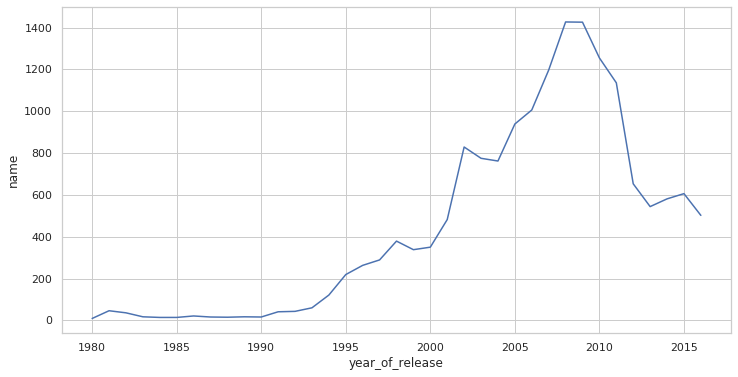

In [16]:
plt.figure(figsize=(12,6))
sns.lineplot(x="year_of_release", y="name",
             palette = "muted",
             data=games_count)

До 1995 года выпуск видеоигр исчисляется парой десятков в год. После выхода Windows и появления первых приставок производство увеличивается в разы.<br>
Для первоначального исследования нас будет интересовать период 1995-2016 годы.<br>

### Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

Построим таблицу распределения суммарных продаж по годам и платформам.
Ограничим период 1992 годом

In [17]:
year_start = 2000
games_start = games.query('year_of_release >= @year_start')

In [18]:
pivot_plarform = (games_start
.pivot_table(index = ['year_of_release', 'platform'], values = 'total_sales', aggfunc = 'sum')
.sort_values(by = 'total_sales', ascending = False)
.reset_index()
)

Нарисуем график - тепловую карту, где по оси X отображены месяцы жизни каждой платформы, а красным цветом обозначены максимальные суммарные продажи игр на этой платформе. 

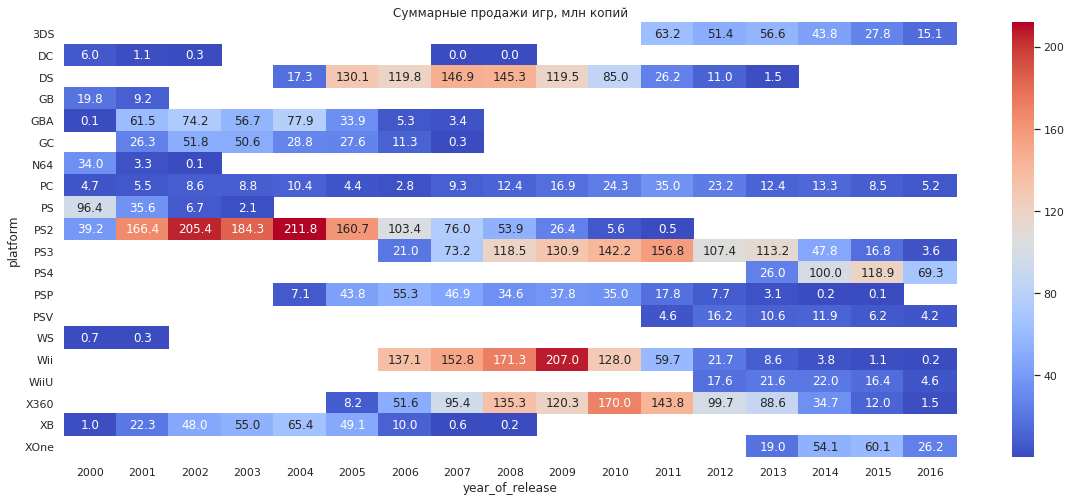

In [19]:
#основа тепловой карты
games_heatmap = (pivot_plarform
.pivot_table(values='total_sales', index='platform', columns='year_of_release')
)

plt.figure(figsize=(20,8))
plt.title('Суммарные продажи игр, млн копий')
sns.heatmap(games_heatmap, cmap='coolwarm', annot=True, fmt=".1f")

Из таблицы видно, что одна платформа в среднем живет около 10-12 лет. У всех платформ есть свой пик продаж примерно в середине жизненного цикла, после которого начинается падение выручки и в итоге уход с рынка. 

Можно сделать вывод, что платформы PS3, X360 и Wii не стоит в будущем рассматривать как перспективные, несмотря на их популярность.  

### Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

### Не учитывайте в работе данные за предыдущие годы.

Определим актуальный период для прогноза на 2017 год. <br>
По графику виден четкий этап появления последних моделей приставок - XOne и PS4, так как именно они будут использоваться в 2017 году, началом актуального периода будем считать 2013 год.

In [20]:
year_actual = 2013

In [21]:
games_actual_year = games.query('year_of_release >= @year_actual')
pivot_actual = pivot_plarform.query('year_of_release >= @year_actual')

### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

Построим графики зависимости продаж от года для всех платформ

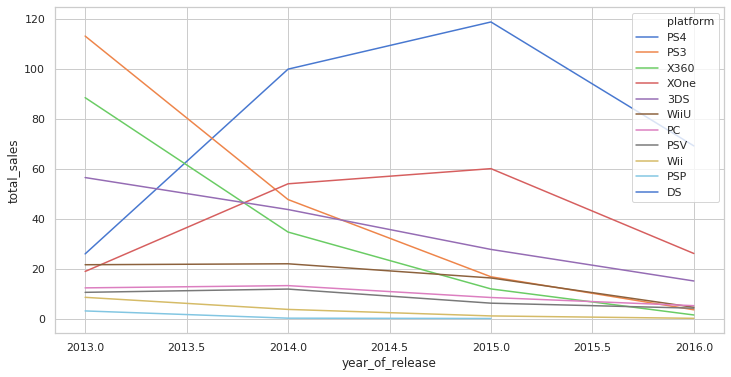

In [22]:
plt.figure(figsize=(12,6))
sns.lineplot(x="year_of_release", y="total_sales",
             hue="platform",
             palette = "muted",
             data=pivot_actual)


Так как данные за 2016 год неполные, на графике мы видим спад. Однако до 2016 года ни одна платформа не может похвастаться ростом. Лидерами продаж являются PS4, XOne и 3DS. <br> Х360 и PS3 плавно сдают позиции. <br>
А наиболее стабильными в этом плане можно назвать WiiU и PC - за весь период практически нет изменений. <br>


Наиболее актуальные платформы выберем по итогам продаж игр за 2015 и начало 2016 года. 

In [23]:
platform_top5 = (games_actual_year.query('year_of_release in (2015,2016)').groupby('platform')
                 .agg({'total_sales': 'sum'})
                 .sort_values(by = 'total_sales', ascending = False).head(5)
                ).reset_index()
#создадим список
platform_top5 = platform_top5['platform']
platform_top5

0     PS4
1    XOne
2     3DS
3    WiiU
4     PS3
Name: platform, dtype: object

### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. <br>Опишите результат.

Ограничим платформы списком тех, что отобрали, и построим боксплоты.

Оценим и удалим выбросы по столбцу `total_sales`

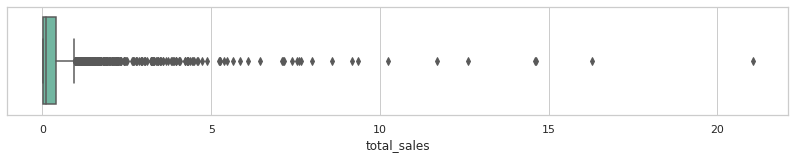

In [24]:
plt.figure(figsize=(14,2))
sns.boxplot(data=games_actual_year, x='total_sales', palette="Set2")

Верхний "ус" боксплота находится на отметке около 1 млн. За усами уже находится зона выбросов, можно добавить еще немного. Если установить границу в 1.5 млн, мы теряем 8% данных, что в принципе приемлемо. 

In [25]:
#срезы данных без выбросов
games_actual = games_actual_year.query('total_sales <= 1.5')

In [27]:
games_actual_top5 = games_actual.query('platform in @platform_top5')

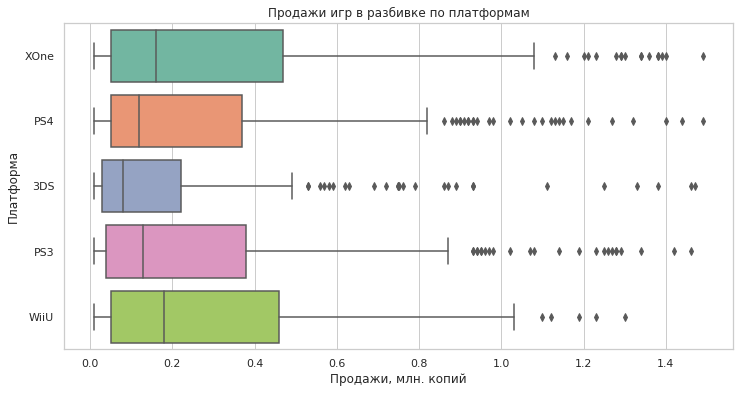

In [28]:
plt.figure(figsize=(12,6))
plt.title('Продажи игр в разбивке по платформам')
ax = sns.boxplot(data=games_actual_top5, x='total_sales',  y='platform', palette="Set2")
ax.set_ylabel("Платформа")
ax.set_xlabel("Продажи, млн. копий");

Датасеты у всех платформ смещены вправо, что говорит о том, что, вероятно, люди предпочитают покупать наиболее известные игры из всего доступного разнообразия. <br>

Лучшие результаты по средним продажам показывают платформы WiiU и XOne.

В период с 2013 по 2016 годы PS4 и PS3 абсолютные победители по глобальным продажам, но по их медианам они не выйдут в лидеры, так как на них выпущено большое количество игр, имеющих продажи, близкие к нулю. <br>
По боксплотам впереди у нас WiiU, на которую игр меньше всего, поэтому пользователи покупают все, что найдут (чем повышают среднее значение продаж) <br>

Ниже график суммы продаж, где как раз самые высокие продажи у PS4.


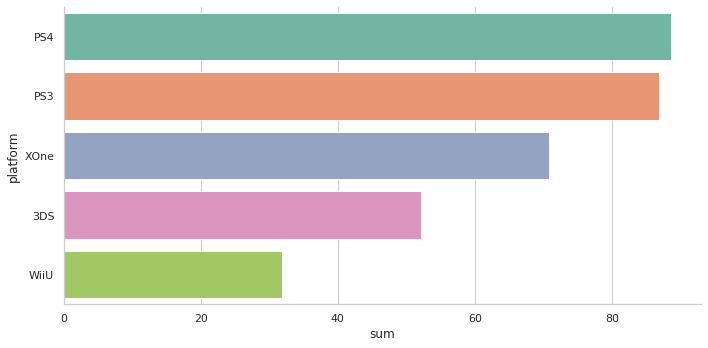

In [29]:
pivot_platform = (games_actual_top5
.pivot_table(index = ['platform'], values = 'total_sales',
             aggfunc = {'sum', 'count'})
.sort_values(by = 'sum', ascending = False)
.reset_index()               
)

ax = sns.catplot(x="sum", y="platform", 
                data=pivot_platform, orient="h",
                kind="bar", ci=None, aspect=2, palette="Set2")

### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.  <BR> Соотнесите выводы с продажами игр на других платформах.

Создадим два датасета, для оценок критиков и оценок пользователей.
За основу возьмем топ-5 платформ.

In [30]:
games_critic_score = games_start.query('platform in @platform_top5 and critic_score > 0')
games_user_score = games_start.query('platform in @platform_top5 and user_score > 0')

Построим диаграммы рассеяния. <br>
Для красоты и наглядности добавим на графики линии регрессии.

**Зависимость продаж от отзывов критиков**

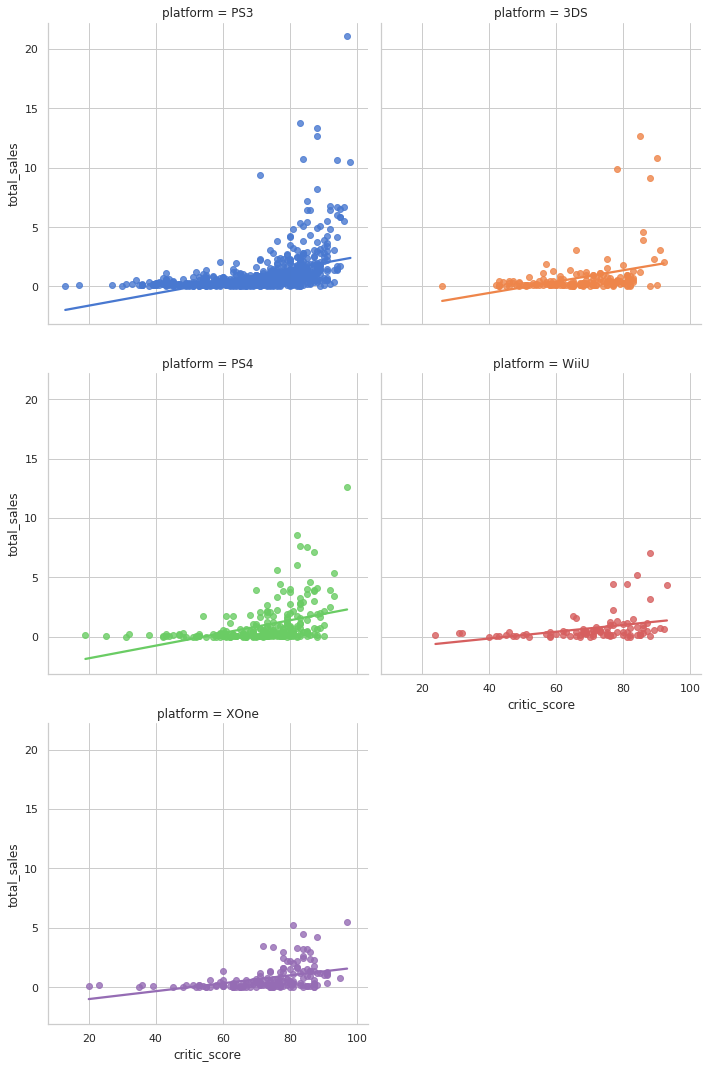

In [31]:
sns.lmplot(x="critic_score", y="total_sales", hue="platform", col_wrap=2,
           height = 5, ci=None, truncate = True,
           col="platform", data= games_critic_score,  palette="muted")

Между отзывами критиков и количеством продаж существует прямая зависимость. Самые высокие цифры продаж у игр с высокой оценкой критиков.

**Зависимость продаж от отзывов пользователей**

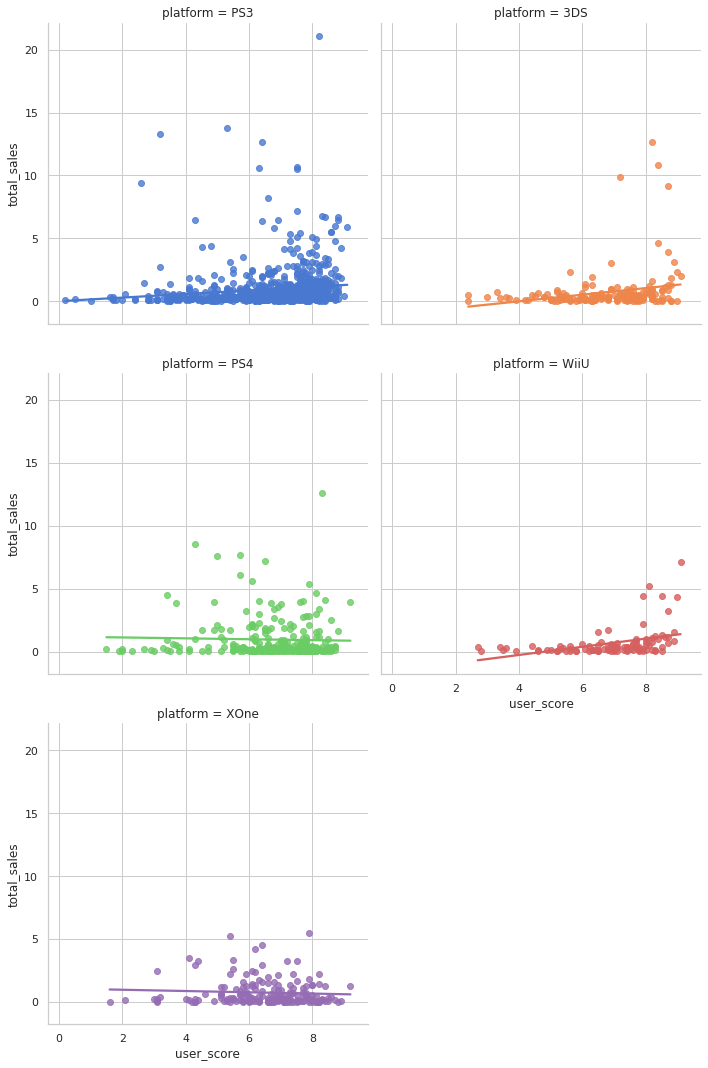

In [32]:
ax = sns.lmplot(x="user_score", y="total_sales", hue="platform", col_wrap=2,
           height = 5, ci=None, truncate = True,
           col="platform", data= games_user_score,  palette="muted")


С зависимостью продаж игр от пользовательской оценки сложилась необычная ситуация - ее нет. 
Только пользователи WiiU и Ниндендо покупают игры с высокой оценкой, остальные просто не обращают на нее внимание. Для пользователей PS4 и XOne зависимость становится обратной - чем хуже оценка, тем лучше продажи.<br>

Вероятно это связано с несовпадением оценки критиков с оценкой пользователей - игра может иметь оценку критиков 80 баллов, но оценку пользователей всего 5.8, при этом покупатели при выборе руководствуются оценкой критиков. 

Подвердим выводы коэффициентами корреляции. 

In [33]:
#создадим пустой датафрейм
d = {'Корреляция': ['critic_score', 'user_score']}
df = pd.DataFrame(data=d)

#заполним колонки для всех платформ из списка
for col in platform_top5:

    a = games_critic_score[(games_critic_score['platform']==col)]['total_sales']
    b = games_critic_score[(games_critic_score['platform']==col)]['critic_score']
    coef = round(b.corr(a),2)
    df.loc[0, col] = coef

    a = games_user_score[(games_user_score['platform']==col)]['total_sales']
    b = games_user_score[(games_user_score['platform']==col)]['user_score']
    coef = round(b.corr(a),2)
    df.loc[1, col] = coef
df

,Корреляция,PS4,XOne,3DS,WiiU,PS3
0,critic_score,0.41,0.42,0.35,0.35,0.43
1,user_score,-0.03,-0.07,0.22,0.40,0.13


**Вывод**
При выборе игры большое значение имеет оценка критиков. Между оценкой критиков и продажами  имеется прямая зависимость, чем выше баллы, тем популярнее игра. Пользовательская оценка значения почти не имеет. 

### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Создадим сводную таблицу продаж игр по жанрам. Рассмотрим все платформы.

In [34]:
pivot_genre = (games_actual
.pivot_table(index = ['genre'], values = 'total_sales',
             aggfunc = {'sum', 'count'})
.sort_values(by = 'sum', ascending = False)
.reset_index()               
)
pivot_genre


,genre,count,sum
0,Action,721,155.18
1,Role-Playing,272,65.59
2,Sports,185,59.32
3,Shooter,141,54.73
4,Misc,145,28.49
5,Adventure,243,20.34
6,Platform,64,20.28
7,Fighting,77,20.11
8,Racing,77,17.38
9,Simulation,59,10.44


Построим диаграмму по глобальным продажам игр

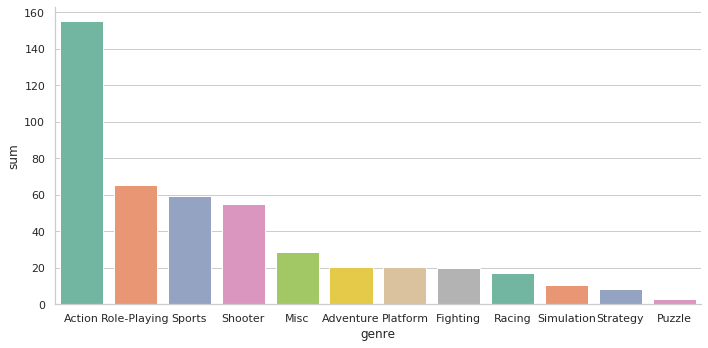

In [35]:
ax = sns.catplot(x="genre", y="sum", 
                data=pivot_genre,
                kind="bar", ci=None, aspect=2, palette="Set2",
                order = pivot_genre['genre'])

Больше всего продаж у игр жанра Action. 
Меньше всего у игр жанра Puzzle.

А также боксплоты

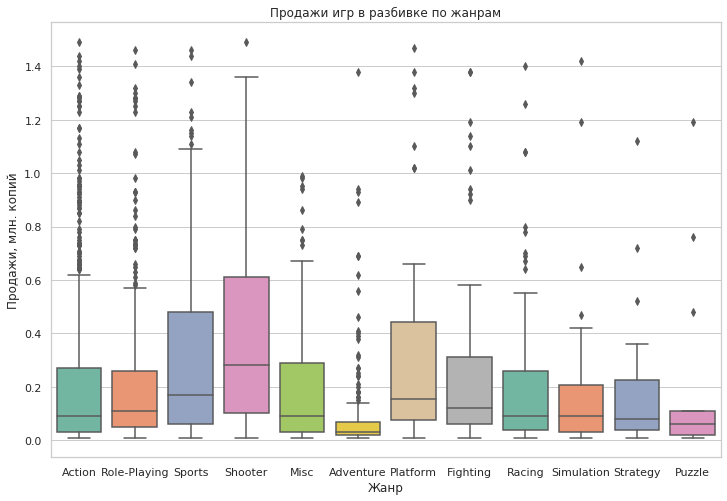

In [36]:
plt.figure(figsize=(12,8))
plt.title('Продажи игр в разбивке по жанрам')
ax = sns.boxplot(data=games_actual, x='genre',  
                 y='total_sales', palette="Set2",
                 order = pivot_genre['genre'])

ax.set_xlabel("Жанр")
ax.set_ylabel("Продажи, млн. копий");


Если Action лидер по общему количеству проданных игр, то самый успешный жанр на сегодняшний день - это Shooter. При небольшом количестве игр он имеет наибольшую долю продаж. <br>

Например, игр в жанре Action было выпущено 721 штука, при этом было продано 155 миллионов копий. <br> 
В жанре Shooter при этом всего 141 игры, при этом продано 54 миллиона копий. То есть продаются они в два раза лучше Action. <br>

Можно сравнить с жанром Adventure - выпущено 243 игр, продано 20 миллионов. Adventure - самые провальные игры, издано их в два раза больше, а продаются они в пять раз хуже, чем шутеры.  <br>

**Вывод:** Action - несомненно, самый прибыльный жанр, но с условием, что игра соответствует ожиданиям потребителей.  Игру низкого качества вряд ли купят, даже если на ней написано "action".


## Шаг 4. Составьте портрет пользователя каждого региона

### Определите для пользователя каждого региона (NA, EU, JP):

#### Самые популярные платформы (топ-5). Опишите различия в долях продаж.

Создадим функцию для создания сводных таблиц для каждого региона. На вход функция принимает название столбца продаж и вид группировки (платформы, жанры). На выходе генерирует топ-5 с сортировкой по доли продаж в общих продажах. 

In [37]:
data_top5 = games

def top_5(param, value):
  
    sum_pt = data_top5[value].sum()

    pt = (data_top5
    .pivot_table(index = [param], values = value, aggfunc = ['sum'])
    ).reset_index()

    #доля в общих продажах
    
    pt['ratio'] = round(pt['sum']/sum_pt,2)*100 
    pt.sort_values(by = 'ratio', ascending = False)
    
    #добавим регион и обрежем название
    pt['region'] = value    
    pt['region'] = pt['region'].str.replace('_sales','')
    
    pt.columns = [param, 'sales', 'ratio', 'region']
    return pt.sort_values(by = 'ratio', ascending = False).head(5)

In [38]:
top_5('platform', 'na_sales') 

,platform,sales,ratio,region
28,X360,602.47,14.0,na
16,PS2,583.84,13.0,na
26,Wii,496.90,11.0,na
4,DS,382.40,9.0,na
17,PS3,393.49,9.0,na


In [39]:
top_5('platform', 'eu_sales')

,platform,sales,ratio,region
17,PS3,330.29,14.0,eu
16,PS2,339.29,14.0,eu
28,X360,270.76,11.0,eu
26,Wii,262.21,11.0,eu
15,PS,213.61,9.0,eu


In [40]:
top_5('platform', 'jp_sales')

,platform,sales,ratio,region
4,DS,175.57,14.0,jp
15,PS,139.82,11.0,jp
16,PS2,139.20,11.0,jp
23,SNES,116.55,9.0,jp
11,NES,98.65,8.0,jp


Создадим общую диаграмму для всех регионам в разбивке по платформам.<br>
По оси Х - платформы, Y - их доли продаж в общих продажах, цветом выделены регионы. 

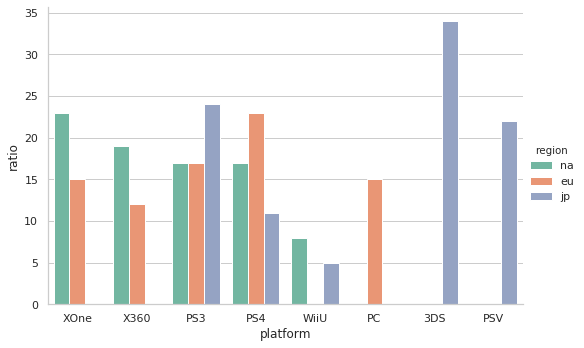

In [41]:
#склеим исходник диаграммы
data_top5 = games_actual
top_platform_all = (top_5('platform', 'na_sales')
                    .append(top_5('platform', 'eu_sales'), ignore_index=True)
.append(top_5('platform', 'jp_sales'), ignore_index=True))

#столбчатая диаграмма для трех регионов
sns.catplot(x="platform", y="ratio",
            kind="bar",  hue="region", 
            palette="Set2",
            aspect=1.5,
            data=top_platform_all)

В США популярность делят между собой XOne и PS4 и их предыдущие версии, а также WiiU. <br>
В Европе многие предпочитают приставке настольный компьютер, а из приставок выбирают Плейстешн.<br>
В Японии определенно предпочитают геймбои - Ниндендо 3DS и PSV. Приставки XOne и X360 при этом игнорируют вовсе.<br>

#### Самые популярные жанры (топ-5). Поясните разницу.

Аналогично в разбивке по жанрам, используем функцию top_5. <br>
По оси Х - жанры, Y - их доли продаж в общих продажах, цветом выделены регионы. 

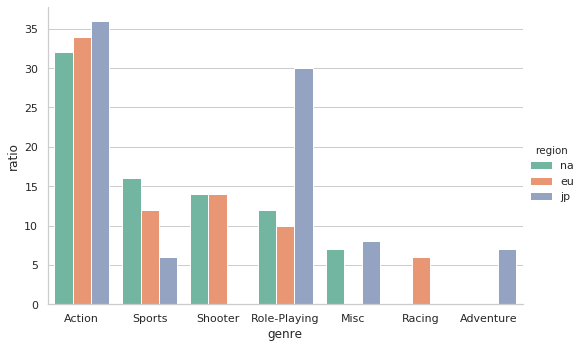

In [42]:
#склеим исходник диаграммы
data_top5 =  games_actual
top_genre_all = (top_5('genre', 'na_sales')
                 .append(top_5('genre', 'eu_sales'), ignore_index=True)
.append(top_5('genre', 'jp_sales'), ignore_index=True)
)
#столбчатая диаграмма для трех регионов
sns.catplot(x="genre", y="ratio",
            kind="bar",  hue="region", 
            palette="Set2",            
            aspect=1.5,
            data=top_genre_all)

Во всех регионах наибольшей популярностью пользуется жанр Action. <br>
В Японии никто не играет в шутеры, но вместо этого играют в Adventures. Большой популярностью пользуется жанр RPG.

#### Влияет ли рейтинг ESRB на продажи в отдельном регионе

Аналогично в разбивке по рейтингу, используем функцию top_5. <br>
По оси Х - рейтинг, Y - доли продаж в общих продажах, цветом выделены регионы. 

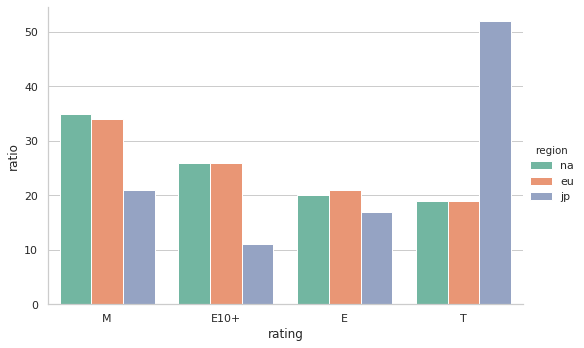

In [43]:
data_top5 = games_actual.query('rating != "Нет данных"') 

top_rating_all = (top_5('rating', 'na_sales').append(top_5('rating', 'eu_sales'), ignore_index=True)
.append(top_5('rating', 'jp_sales'), ignore_index=True))


sns.catplot(x="rating", y="ratio",
            kind="bar",  hue="region", 
            palette="Set2",
            aspect=1.5,
            data=top_rating_all)



«T» («Teen») — «Подросткам» <br>
«M» («Mature») — «Для взрослых»<br>
«E» («Everyone») — «Для всех»<br>
«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»<br>
«RP» («Rating Pending») — «Рейтинг ожидается». Данный логотип используется только на рекламных презентациях и в демо-версиях игр.

В Японии в игры играют в основном подростки и почти не играют дети.<br>
В США и Европе одинаковой популярностью пользуются игры для детей и игры для взрослых с расчлененкой и насилием. <br>

Ситуацию с отсутствующим рейтингом рассмотрим отдельно

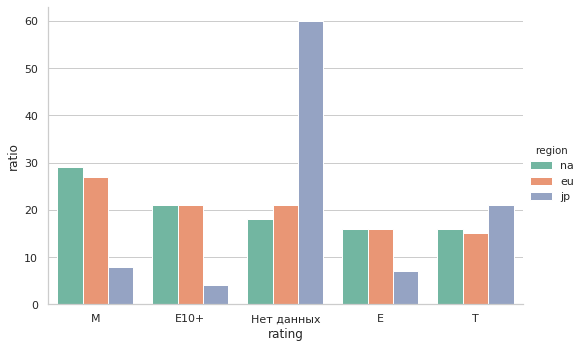

In [44]:
data_top5 = games_actual

top_rating_all = (top_5('rating', 'na_sales').append(top_5('rating', 'eu_sales'), ignore_index=True)
.append(top_5('rating', 'jp_sales'), ignore_index=True))

sns.catplot(x="rating", y="ratio",
            kind="bar",  hue="region", 
            palette="Set2",
            aspect=1.5,
            data=top_rating_all)

В регионе Японии также ни создатели, ни покупатели игр не придают значения системе мирового рейтинга и на внутренний рынок выпускают игры без него. 


**Вывод:** Портрет пользователя США - это взрослый человек, предпочитающий игры жанров Action, Shooter и Sports для приставок PS4, XOne или WiiU или ребенок, играющий в игры типа Misc (разнообразные вне категорий).

Портрет пользователя Европы - это человек, предпочитающий игры жанров Action, Shooter, Sports и RPG для приставки PS4 и настольного компьютера.

Портрет пользователя Японии - это тинейджер, играющий в RPG и Action на портативном устройстве 3DS или PSV. 

## Шаг 5. Проверьте гипотезы

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

Сформулируем нулевую и альтернативную гипотезы:

H₀ = средние пользовательские рейтинги платформ Xbox One и PC одинаковые.<br>
H₁ = средние пользовательские рейтинги платформ Xbox One и PC не одинаковые.<br>

Рассмотрим две совокупности и сравним дисперсии

In [46]:
hyp_data1 = games_actual.query('platform == "XOne"and user_score > 0')['user_score']
hyp_data2 = games_actual.query('platform == "PC"and user_score > 0')['user_score']

print('Дисперсия первой совокупности:',np.var(hyp_data1))
print('Дисперсия второй совокупности:',np.var(hyp_data2))

Дисперсия первой совокупности: 1.9463575442247658
Дисперсия второй совокупности: 3.0016378316032295


In [47]:
from scipy import stats as st
alpha = 0.05

print('cреднее XOne: ', hyp_data1.mean())
print('cреднее PC: ', hyp_data2.mean())

results = st.ttest_ind(hyp_data1, hyp_data2)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:    
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

cреднее XOne:  6.578064516129033
cреднее PC:  6.2745098039215685
p-значение: 0.09221555627195357
Не получилось отвергнуть нулевую гипотезу


**Вывод**<br>
Мы не отвергли гипотезу, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.<br>
(итого - рейтинги одинаковые)

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Сформулируем нулевую и альтернативную гипотезы:

H₀ = средние пользовательские рейтинги жанров Action и Sports одинаковые.<br>
H₁ = средние пользовательские рейтинги жанров Action и Sports разные.<br>

In [48]:
hyp_data1 = games_actual.query('genre == "Action" and user_score > 0')['user_score']
hyp_data2 = games_actual.query('genre == "Sports" and user_score > 0')['user_score']

In [49]:
from scipy import stats as st
alpha = 0.05

print('cреднее Action: ', hyp_data1.mean())
print('cреднее Sports: ', hyp_data2.mean())

results = st.ttest_ind(hyp_data1, hyp_data2)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:    
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

cреднее Action:  6.7948571428571425
cреднее Sports:  5.251145038167938
p-значение: 1.2896436425404313e-21
Отвергаем нулевую гипотезу


**Вывод**<br>
Мы отвергли гипотезу, что средние пользовательские рейтинги жанров Action и Sports одинаковые.<br>
(итого - рейтинги разные)

## Шаг 6. Напишите общий вывод

Мы проанализировали данные о продажах видеоигр за период с 1980 по 2016 годы, полученные из открытых источников и определили потенциальные закономерности потенциально популярного продукта. 

Актуальный период исследования для прогноза на 2017 год был определен как 2013-2016 годы.

Наиболее перспективными игровыми платформами будут являться PlayStation 4, PlayStation 3 и Xbox One, а в регионе Япония - Nindendo 3DS.

Самый продаваемый жанр игры - это Action, а также RPG, Shooter и Sports.

При создании рекламной компании необходимо уделить внимание критическим обзорам, так как высокая оценка критиков прямо влияет на продажи игры. 

Кроме того, мы проверили гипотезы и определили, что:
- cредние пользовательские рейтинги платформ Xbox One и PC одинаковые.
- cредние пользовательские рейтинги жанров Action и Sports разные.


